## Data analysis in figure 4.

To reproduce this notebook, please download following data from [Zenodo repository](https://doi.org/10.5281/zenodo.10925338).

- Sequenced fragments that represents MyoD positions.
  - Pair_MyoD-RNAP2_Mesoderm.bed.gz
  - Pair_MyoD-RNAP2_Myocyte.bed.gz
- Sequenced fragments that represents RNA PolII positions.
  - RNAP2_MyoD-RNAP2_Mesoderm.bed.gz
  - RNAP2_MyoD-RNAP2_Myocyte.bed.gz
- Seurat object; the result of analizing PolII fragment counted by gene body.
  - RNAP2_MyoD_subset_SeuratObject.rds
- Table summarizing the analysis.
  - RNAP2_MyoD-RNAP2_metaTable.tsv

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(Seurat)
library(GenomicRanges)
library(GenomicAlignments)
library(chromVAR)
library(SummarizedExperiment)
library(motifmatchr)
library(universalmotif)
library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)
source('mytools.R')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object i

In [2]:
pol2m <- readRDS('RNAP2_MyoD_subset_SeuratObject.rds')
pol2m_meta <- read_tsv('RNAP2_MyoD-RNAP2_metaTable.tsv',show_col_types = F)
myodfrags <- list('Pair_MyoD-RNAP2_Mesoderm.bed.gz','Pair_MyoD-RNAP2_Myocyte.bed.gz') %>%
  map(rtracklayer::import,format = 'bed') %>% do.call(c,.)
pol2frags <- list('RNAP2_MyoD-RNAP2_Mesoderm.bed.gz','RNAP2_MyoD-RNAP2_Myocyte.bed.gz') %>%
  map(rtracklayer::import,format = 'bed') %>% do.call(c,.)

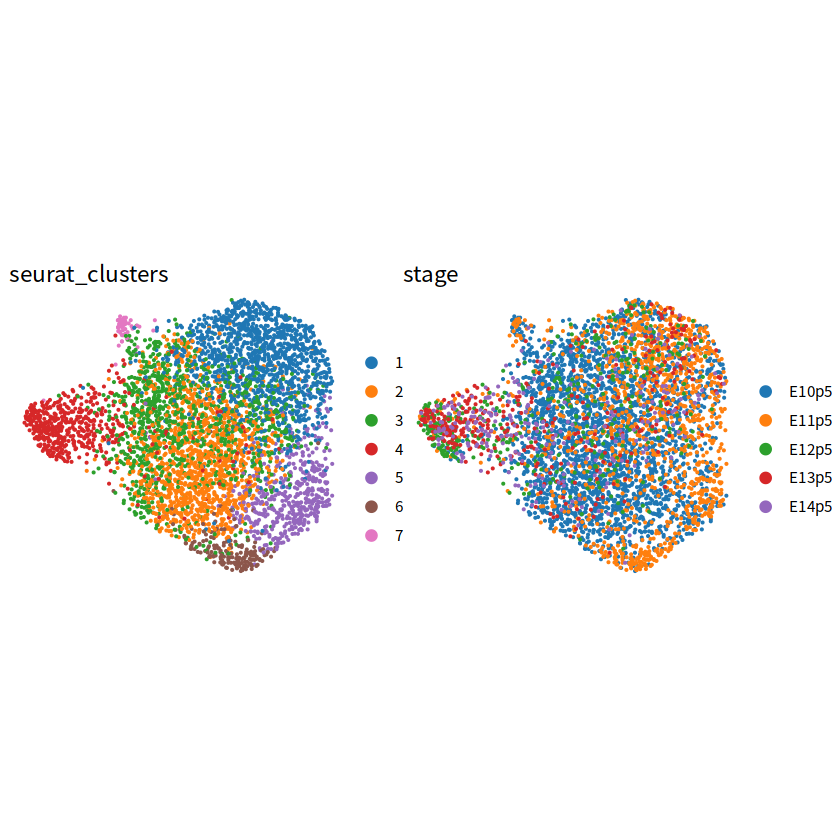

In [3]:
um1 <- dimplot(pol2m,'seurat_clusters',Theme = theme_void)
um2 <- dimplot(pol2m,'stage',Theme = theme_void)
um1|um2

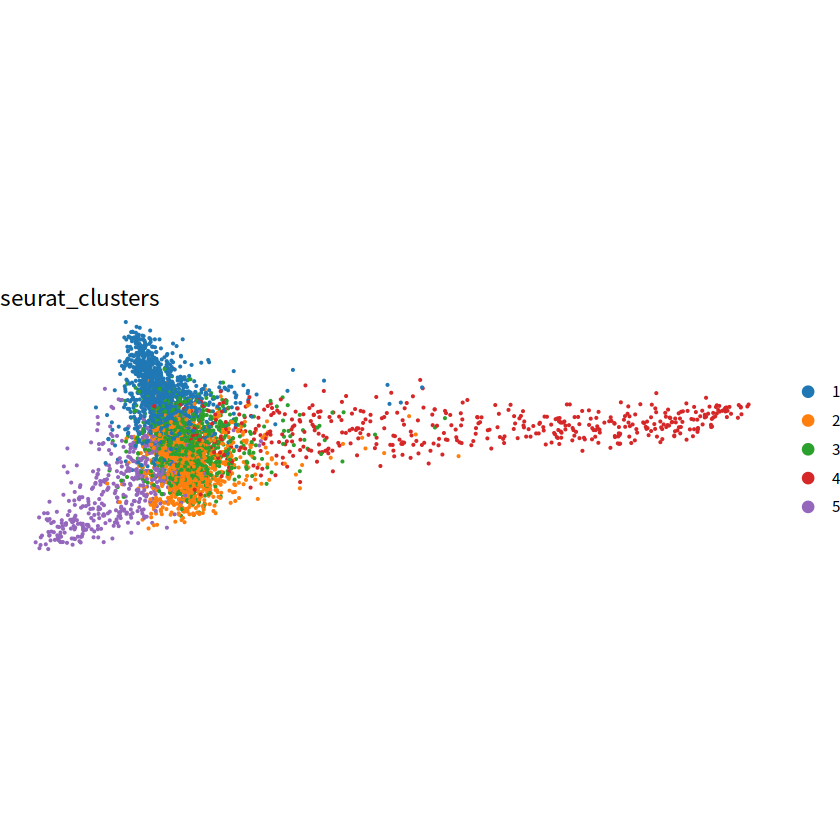

In [4]:
pol2msub <- pol2m %>%
  subset(seurat_clusters %in% c(1:5))
ph <- dimplot(pol2msub,'seurat_clusters',reduction = 'phate',Theme = theme_void)
ph

### Pseudo time inference using slingshot

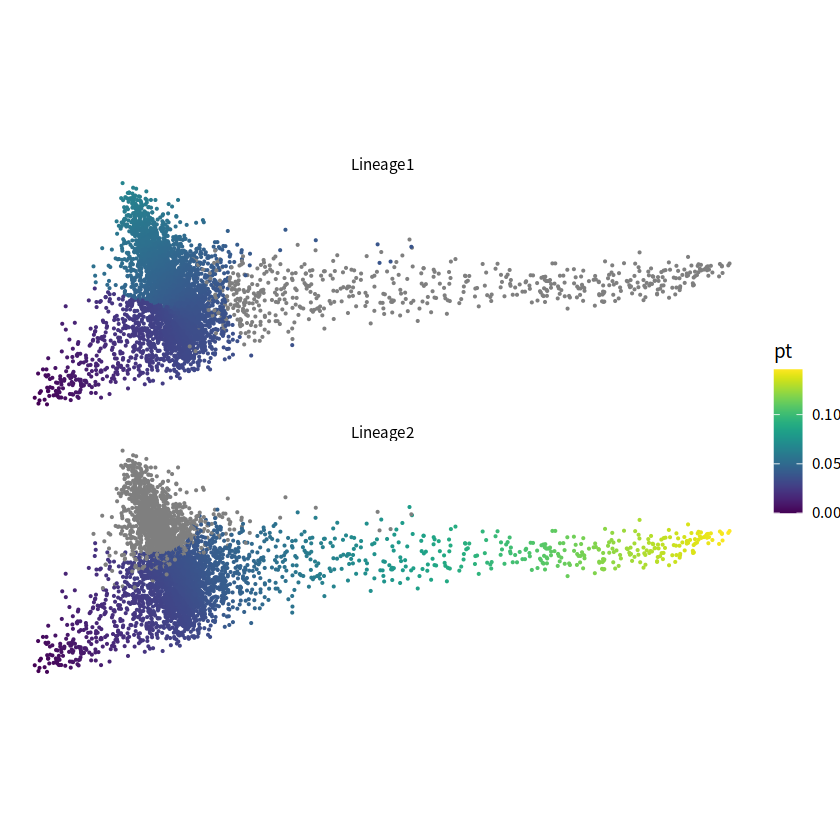

In [5]:
tab_pol2msub <- seu2tab(pol2msub) %>%
  select(cell,UMAP1,UMAP2,stage,celltype,seurat_clusters)
clus <- as.character(tab_pol2msub$seurat_clusters)
names(clus) <- rownames(tab_pol2msub$cell)
df <- Embeddings(pol2msub[['phate']])
colnames(df) <- c('PHATE1','PHATE2')
suppressWarnings(lin <- slingshot::getLineages(df, clus, start.clus = '5'))
crv <- slingshot::getCurves(lin)
pt <- slingshot::slingPseudotime(crv) %>%
  as_tibble(rownames = 'cell') %>%
  gather(key = lineage,value = pt,-cell)

tab_pol2msub <- bind_cols(tab_pol2msub,df)
tab_pol2msub_pt <- tab_pol2msub %>%
  left_join(pt,by = 'cell')

ph_pts <- tab_pol2msub_pt %>%
  style('pt',reduction = 'PHATE',Theme = theme_void)  + facet_wrap(~lineage,nrow=2)
ph_pts

#### Dynamics of MyoD count per cell in development

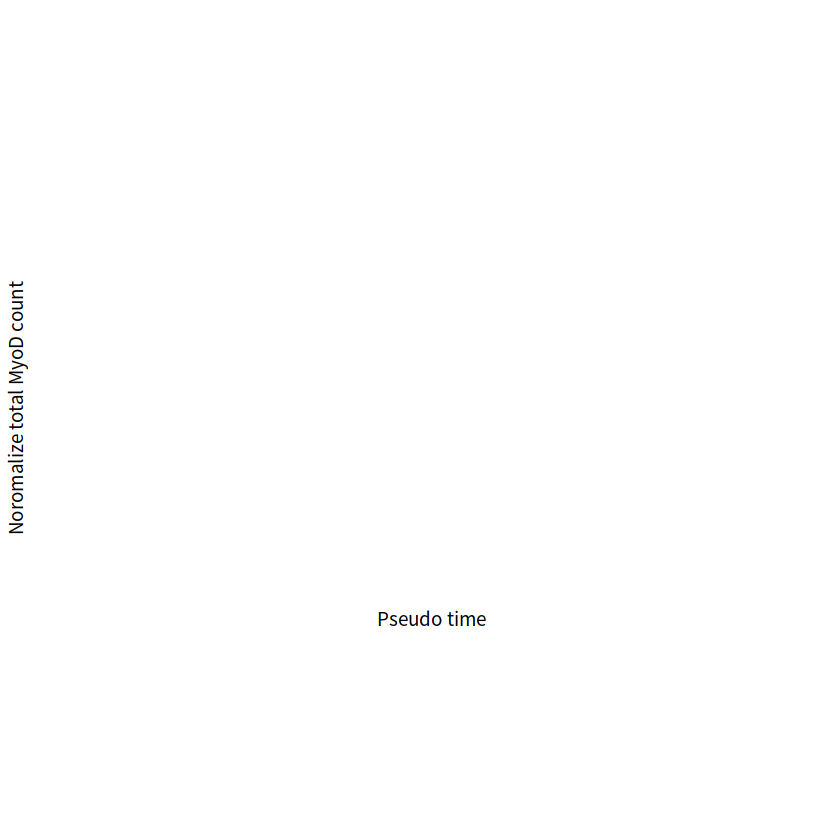

In [6]:
norm_myod <- inner_join(
  tab_pol2msub_pt %>% select(cell,lineage,pt) %>% na.omit(),
  pol2m_meta %>% select(cell,nRead_RNAP2,nRead_Pair),
  by = 'cell'
  ) %>%
  mutate(norm = nRead_Pair/nRead_RNAP2)
norm_myod_dyn <- norm_myod %>%
  ggplot(aes(pt,norm,color = lineage)) + 
  geom_smooth() + theme_minimal() + ylim(c(0,NA)) +
  theme(aspect.ratio = .5) +
  labs(x = 'Pseudo time',y = 'Noromalize total MyoD count') +
  scale_color_manual(values = defcols(4)[c(1,3)])

norm_myod_dyn

#### Dynamics of transcption activity of MyoD and other genes

In [7]:
if(file.exists('data/mgene_ucsc.rds')){
  mgene <- readRDS('data/mgene_ucsc.rds')
}else{
  mgene <- GenomicFeatures::genes(EnsDb.Mmusculus.v79::EnsDb.Mmusculus.v79)
  GenomeInfoDb::seqlevelsStyle(mgene) <- "UCSC"
}
mgene_codings <- mgene %>% subset(gene_biotype=='protein_coding')
idx <- as_tibble(mgene_codings) %>% arrange(-width) %>% filter(!duplicated(symbol)) %>% pull(gene_id)
mgene_codings <- mgene_codings %>% subset(gene_id %in% idx)
mgene_codings_exD5k <- extend(mgene_codings,upstream = 0,downstream = 5000)

In [8]:
smat_exD5k <- findOverlapPairs(pol2frags,mgene_codings_exD5k) %>%
  {tibble(cell = .@first$name,
          gene  = .@second$gene_name)} %>%
  dplyr::count(cell,gene) %>%
  ol2sm("cell","gene","n")

In [9]:
slpt <- slingshot::slingPseudotime(crv, na = FALSE)
weights <- slingshot::slingCurveWeights(crv)
usegs <- c("Myod1","Myf5","Myog","Myh3","Runx2","Meis2")
smat_exD5k_ <- smat_exD5k[usegs,rownames(slpt)]
sce_subex <- tradeSeq::fitGAM(
  counts = smat_exD5k_,
  pseudotime = slpt, 
  cellWeights = weights,
  nknots = 5, verbose = TRUE
  )

TMM normalization failed. Will use unnormalized library sizesas offset.


Some library sizes are zero. Offsetting these to 1.




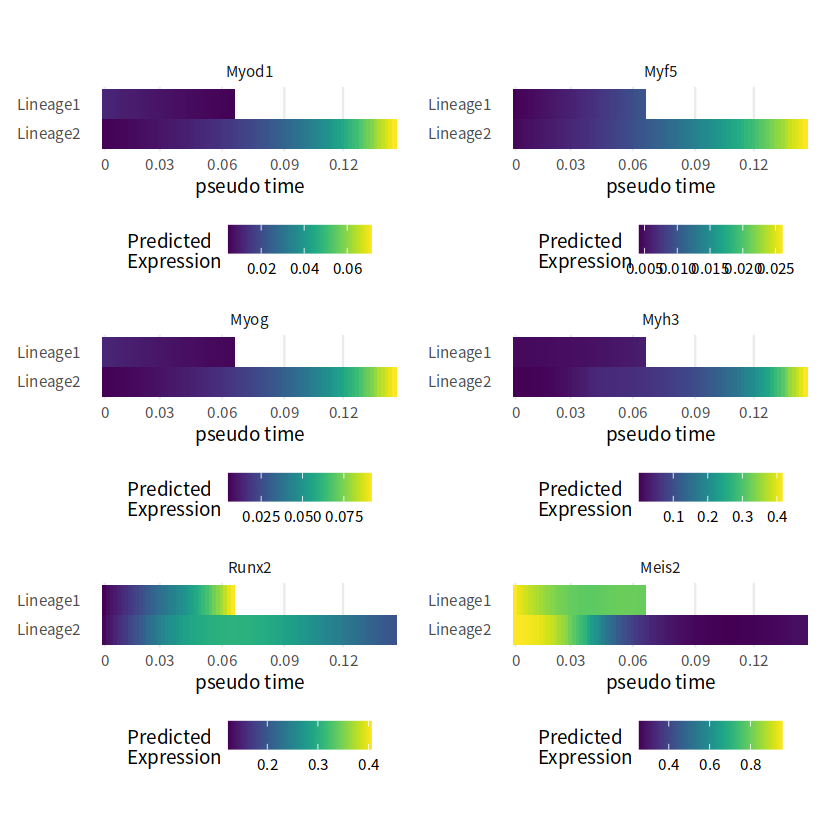

In [10]:
Maxpt <- sce_subex$crv %>% 
  as_tibble() %>% gather(Lineage,pt) %>% 
  filter(str_detect(Lineage,'pseudotime')) %>% 
  reframe(maxpt = max(pt),.by = 'Lineage') %>%
  mutate(Lineage = sub(".*\\.","",Lineage)) %>%
  deframe()
pred <- predGAM(sce_subex,smat_exD5k_,usegs) %>%
  mutate(time_idx = floor(80*pt/max(Maxpt)),
         time_idx = ifelse(time_idx == 0,1,time_idx)) %>%
  reframe(smoothed = mean(smoothed),pt = mean(pt),.by = c(gene,time_idx,Lineage))
breaks_ <- pred %>% distinct(time_idx,pt) %>% mutate(a = pt%/%0.03,b = pt%%0.03) %>% arrange(b,a) %>% 
  reframe(time_idx = head(time_idx,1),pt = head(pt,1),.by = a)
txs <- usegs %>%
  map(~{
    pred %>% filter(gene == .x) %>%
      ggplot(aes(time_idx,Lineage,fill = smoothed)) +
      theme_minimal() + geom_tile() + 
      viridis::scale_fill_viridis() +
      facet_wrap(~gene) +
      theme(legend.position = 'bottom',aspect.ratio = .2,
            panel.grid.minor = element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(x = 'pseudo time',
           fill = 'Predicted\nExpression') +
      scale_y_discrete(limits = rev) +
      scale_x_continuous(breaks = breaks_$time_idx,labels = round(breaks_$pt,digits = 2))
  }) %>%
  patchwork::wrap_plots(ncol=2)
txs

### Motif enrichment analysis at MyoD binding cites

#### Extract cells at start, branch and terminal point in this dataset

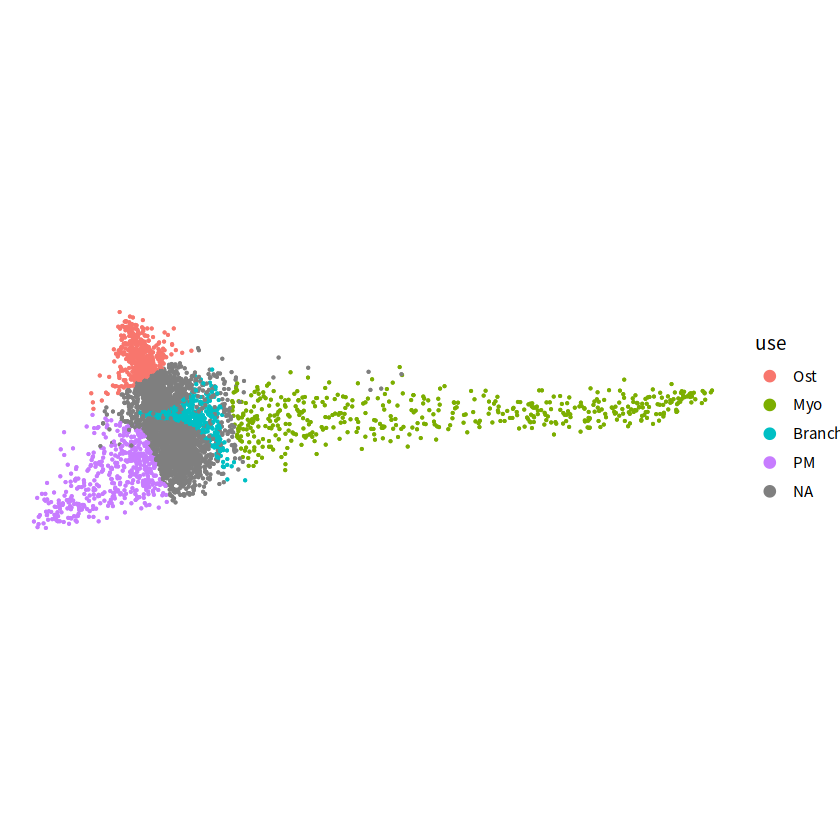

In [11]:
tmp <- tab_pol2msub_pt %>%
  na.omit() %>%
  split(.$lineage) %>%
  map(~{.x %>% arrange(-pt) %>% head(500)}) %>%
  structure(names = c('Ost','Myo'))
cells_int <- tab_pol2msub_pt %>%
  filter(!is.na(pt)) %>%
  dplyr::count(cell) %>% filter(n==2)
tab_int <- tab_pol2msub_pt %>%
  filter(cell %in% cells_int$cell) %>%
  reframe(pt = mean(pt),.by = cell) %>%
  arrange(-pt)
cells <- list(Branch = head(tab_int,nrow(tmp$Myo)),
              PM = tail(tab_int,nrow(tmp$Myo)))
cells <- c(tmp,cells) %>%
  bind_rows(.id = 'use') %>%
  select(cell,use) %>%
  filter(!duplicated(cell))
ph_use <- tab_pol2msub_pt %>%
  left_join(cells,by = 'cell') %>%
  mutate(use = factor(use,levels = c("Ost","Myo","Branch","PM"))) %>%
  style('use',reduction = 'PHATE',palette = F,Theme = theme_void,size = .1)
ph_use

In [12]:
binSize <- 1000
myod_1ksm <- myodfrags %>%
  as_tibble() %>% 
  filter(name %in% colnames(pol2msub)) %>%
  mutate(center = (start+end)/2,
         idx = round(center/binSize)) %>%
  dplyr::count(seqnames,idx,name) %>%
  mutate(start = binSize*idx - (binSize/2),end = binSize*idx + (binSize/2) - 1) %>%
  unite(reg,seqnames,start,end) %>%
  ol2sm("name","reg")

#### Motif enrichment analysis using chromVAR

In [13]:
db <- readRDS('data/motifs_pwm.rds') 
## from JASPAR2020 CORE

labs <- tibble(id = names(db)) %>%
  mutate(name = map(id,~{db[[.x]]@name})) %>%
  unnest(name)
bhlh <- read_tsv("data/bHLH_gens.tsv",show_col_types = F) %>%
  select(Clade,Mouse) %>%
  na.omit() %>% mutate(Mouse = str_split(Mouse,', ')) %>%
  unnest(Mouse) %>% mutate(Mouse = sub("\\(.*","",Mouse)) 
## from skinner et. al., Differentiation, 2010

uselab <- labs %>%
  filter(tolower(name) %in% tolower(bhlh$Mouse)) %>%
  pull(id) %>% unique()

In [14]:
counts <- myod_1ksm[,cells$cell]
counts <- counts[rowSums(counts>0)>=5,]
mod <- model.matrix(~cells$use -1)
colnames(mod) <- sub("cells\\$use","",colnames(mod))
mod <- t(t(mod)/colSums(mod))
counts <- counts %*% mod
counts <- t(10000*t(counts)/colSums(counts))
rowRanges <- tibble(reg = rownames(counts)) %>%
  separate(reg,into = c('seqnames','start','end')) %>%
  mutate(start = as.double(start),end = as.double(end)) %>%
  with(GRanges(seqnames,IRanges(start,end)))

cnt <- SummarizedExperiment(
  assays = list(counts = counts),
  rowRanges = rowRanges) %>%
  addGCBias(genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ixs <- matchMotifs(
  db[uselab], cnt,
  genome = BSgenome.Mmusculus.UCSC.mm10
  )
dev <- computeDeviations(object = cnt, annotations = motif_ixs)
devZ <- deviationScores(dev)

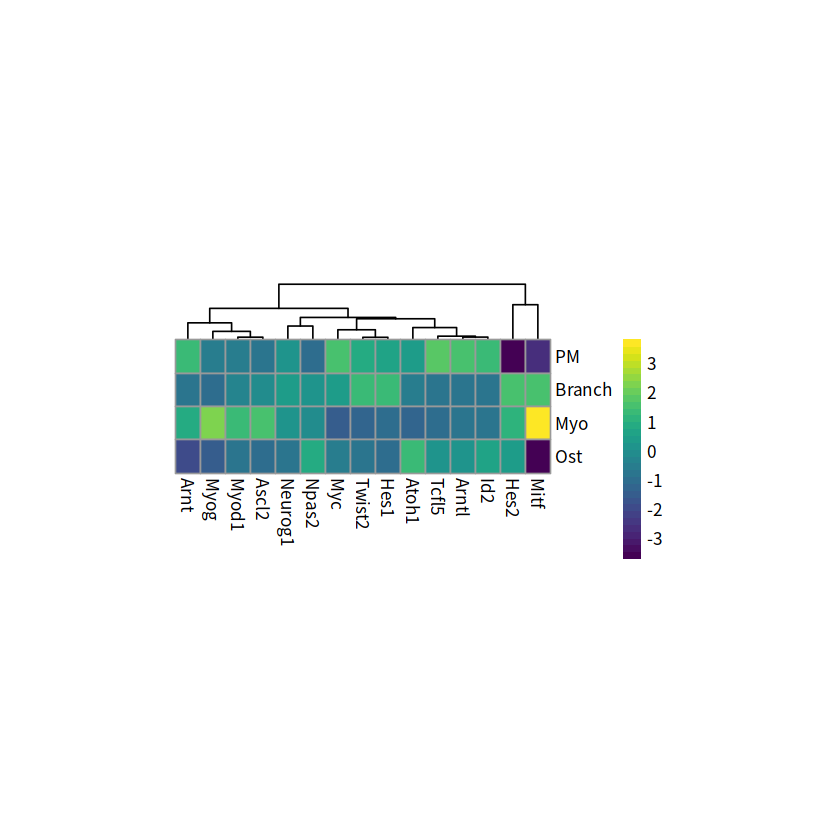

In [15]:
labs_ <- labs %>% filter(id %in% uselab)
devZ2 <- devZ[labs_$id,]
rownames(devZ2) <- labs_$name
devZ2 <- t(devZ2[,c('PM','Branch','Myo','Ost')])
pheatmap::pheatmap(
  devZ2,cluster_rows = F,cellwidth = 15,cellheight = 20,
  treeheight_col = 30,color = viridis::viridis(32))

In [16]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3                    forcats_1.0.0                     
 [3] stringr_1.5.1                      dplyr_1.1.4                       
 [5] purrr_1.0.2                        readr_2.1.5                       
